In [1]:
# %load_ext iminizinc
%load_ext autoreload
%autoreload 2

from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
# import ipywidgets as widgets
from ipywidgets import *
from IPython.display import display
import IPython
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

from datetime import datetime
# import talib
import pandas_ta as ta
# from talib.abstract import *
from math import *
from collections import OrderedDict
# import vectorbt as vbt    
import json
from decimal import *
getcontext().prec = 6
import seaborn as sns
from scipy.signal import find_peaks, peak_widths
import pickle


import sys, os
sys.path.append(os.path.abspath('..'))
from research.pkg.lib import *


# import mplfinance as mpf
%matplotlib inline

# plt.rcParams['lines.linewidth'] = 0.5 



In [2]:
from minizinc import Instance, Model, Solver, Status as mzStatus
import nest_asyncio
nest_asyncio.apply()

In [10]:

def call_mzn_model(model_name,model_params):
    with open(f'pars-{model_name}.dzn.json', 'w+') as f: f.write(json.dumps(model_params, indent=2))

    # print('Model params:', model_params)

    mzn_model = Model(f'{model_name}.mzn')
    gecode = Solver.lookup("gecode")
    instance = Instance(gecode, mzn_model)

    for k,v in model_params.items(): instance[k] = v
    result = instance.solve()

    return result


In [172]:
pair = 'ADA_USDT'
timeframe = '2h'

exchange = 'binance'
odf = pd.read_json(f'../freq-user-data/data/{exchange}/{pair}-{timeframe}.json'
# exchange = 'kucoin'
# odf = pd.read_json(f'../../freq-user-data/data/{exchange}/futures/{pair}-{timeframe}-futures.json'
).dropna().set_axis(['timestamp', 'open', 'high', 'low', 'close', 'volume'], axis=1
).assign(dtime=lambda x: pd.to_datetime(x['timestamp'], unit='ms', utc=False)
).set_index('dtime').sort_index()

print(odf.shape)
odf.head(4)

(22185, 6)


,timestamp,open,high,low,close,volume
dtime,,,,,,
2018-04-17 04:00:00,1523937600000,0.25551,0.28800,0.25551,0.26200,16461616.84
2018-04-17 06:00:00,1523944800000,0.26221,0.26396,0.24800,0.25698,13106139.32
2018-04-17 08:00:00,1523952000000,0.25636,0.25998,0.25229,0.25536,6189649.64
2018-04-17 10:00:00,1523959200000,0.25625,0.26200,0.25320,0.26129,4114643.27


In [173]:
wdf = odf.copy()
wdf['cadir'] = 1 - 2*(wdf.close < wdf.open).astype(int)
# wdf
mzn_res = call_mzn_model('last-such', {'markers': wdf.cadir.values.tolist()})
wdf['n_prev'] = mzn_res['prev']
wdf['n_next'] = mzn_res['next']
# wdf['n_downs'] = call_mzn_model('last-such', {'markers': (wdf.cadir == -1).astype(int).values.tolist()})['result']
# wdf['n_ups'] = call_mzn_model('last-such', {'markers': (wdf.cadir == 1).astype(int).values.tolist()})['result']

# wdf['pn_dir'] = wdf.n_dir.shift().fillna(0).astype(int)
wdf.to_csv('test.csv')
# call_mzn_model('last-such', {'markers': (wdf.cadir == 1).astype(int).values.tolist()})

<Axes: >

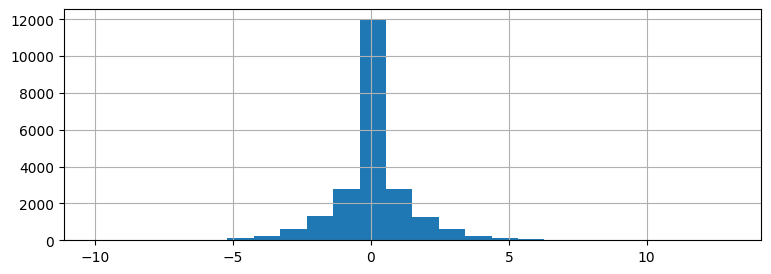

In [174]:
# wdf.n_dir.describe(), wdf.n_dir.value_counts()
wdf.n_prev.hist(bins=wdf.n_prev.unique().shape[0],figsize=(9,3))

In [175]:
wdf['lret'] = wdf.close.divide(wdf.open).apply(np.log)
wdf

,timestamp,open,high,low,close,volume,cadir,n_prev,n_next,lret
dtime,,,,,,,,,,
2018-04-17 04:00:00,1523937600000,0.25551,0.28800,0.25551,0.26200,16461616.84,1,0,0,0.025083
2018-04-17 06:00:00,1523944800000,0.26221,0.26396,0.24800,0.25698,13106139.32,-1,0,-1,-0.020147
2018-04-17 08:00:00,1523952000000,0.25636,0.25998,0.25229,0.25536,6189649.64,-1,-1,0,-0.003908
2018-04-17 10:00:00,1523959200000,0.25625,0.26200,0.25320,0.26129,4114643.27,1,0,0,0.019477
2018-04-17 12:00:00,1523966400000,0.26097,0.26660,0.25596,0.25751,5764460.20,-1,0,-1,-0.013347
...,...,...,...,...,...,...,...,...,...,...
2023-05-12 10:00:00,1683885600000,0.36630,0.36730,0.36410,0.36440,8171362.90,-1,0,-3,-0.005201
2023-05-12 12:00:00,1683892800000,0.36450,0.36760,0.36320,0.36400,9751739.90,-1,-1,-2,-0.001373
2023-05-12 14:00:00,1683900000000,0.36390,0.36580,0.35900,0.35940,9566903.60,-1,-2,-1,-0.012443


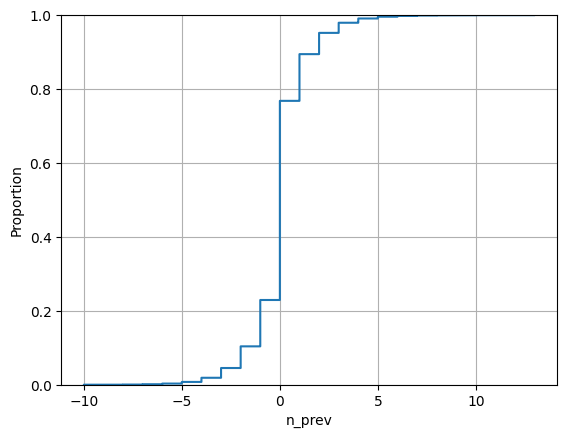

In [176]:
idf = wdf.copy()
# print(idf[wdf.cadir==-1].n_downs.value_counts())
sns.ecdfplot(idf.n_prev)
plt.grid()

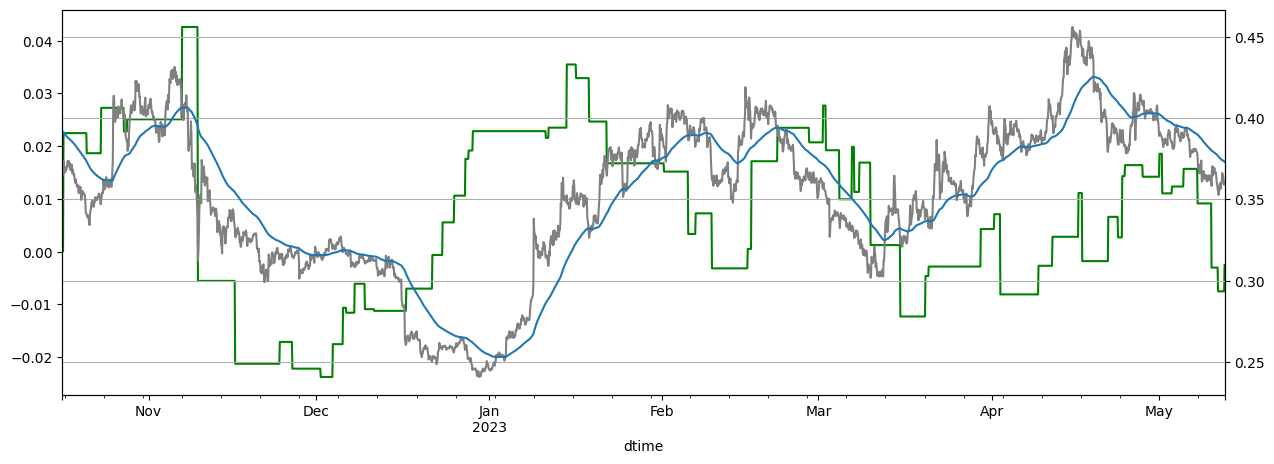

In [245]:
n_prev = -3
wdf['ema'] = wdf.close.ewm(span=120).mean()
wdf['nstd'] = wdf.close.rolling(abs(n_prev * 2)).std().shift().bfill()
# wdf['sig'] = (idf.n_prev == n_prev)

wdf['stop_loss'] = wdf.open - 2.5 * wdf.nstd
wdf['pos_exit'] = wdf.close
wdf['stop_lret'] = wdf.stop_loss.divide(wdf.open).apply(np.log)
wdf['pos_exit_lret'] = wdf.pos_exit.divide(wdf.open).apply(np.log)

tdf = wdf.iloc[-2500:,:].copy()

sig = (tdf.n_prev == n_prev)
sig_df = tdf.loc[sig.shift().fillna(False)].copy()
sig_df['pnl'] = np.where(sig_df.low < sig_df.stop_loss, sig_df.stop_lret, sig_df.pos_exit_lret)# - 0.002

tdf['pnl'] = tdf[[]].join(sig_df.pnl).fillna(0)
ax1 = tdf.pnl.cumsum().plot(figsize=(15,5), c='g')
ax2 = ax1.twinx()
tdf.close.plot(ax=ax2, c='gray')
tdf.ema.plot(ax=ax2)
plt.grid()

In [235]:
tdf[[]].join(sig_df.pnl).fillna(0)

,pnl
dtime,
2023-04-01 04:00:00,0.000000
2023-04-01 06:00:00,0.000000
2023-04-01 08:00:00,0.000000
2023-04-01 10:00:00,-0.004049
2023-04-01 12:00:00,0.000000
...,...
2023-05-12 10:00:00,0.000000
2023-05-12 12:00:00,0.000000
2023-05-12 14:00:00,0.000000
